# Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import streamlit as st
from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient
from scipy.stats import norm
from datetime import datetime, timedelta
import random

from ab_testing.constants import client_name, target_col
from ab_testing.data_acquisition.acquire_data import queries_dict  # AcquireData
from ab_testing.distribution_fit.fit_distribution import FitDistribution
from ab_testing.predictions.produce_predictions import ProducePredictions
from bayesian_testing.experiments import BinaryDataTest, DeltaLognormalDataTest

In [2]:
configure_offline_feature_store(workgroup="development", catalog_name="production")

In [3]:
client_name = 'bingo_aloha'

start_date = datetime(2022,10,11)
end_date = datetime(2022,12,9)
dates_list = [(start_date + timedelta(days=x)) for x in range((end_date-start_date).days + 1)]

In [4]:
initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
        queries_dict[client_name]
    )

2022-12-11 11:05:22,504 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


Missing STATSD_HOST and/or STATSD_PORT environment variables
DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:466.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:4898.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:35223518|c


2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00


<AxesSubplot:title={'center':'CONVERSION RATE TEST: Expected losses (if the other variant is chosen) over the period of running the test'}, ylabel='Expected loss (in conversion rate units)'>

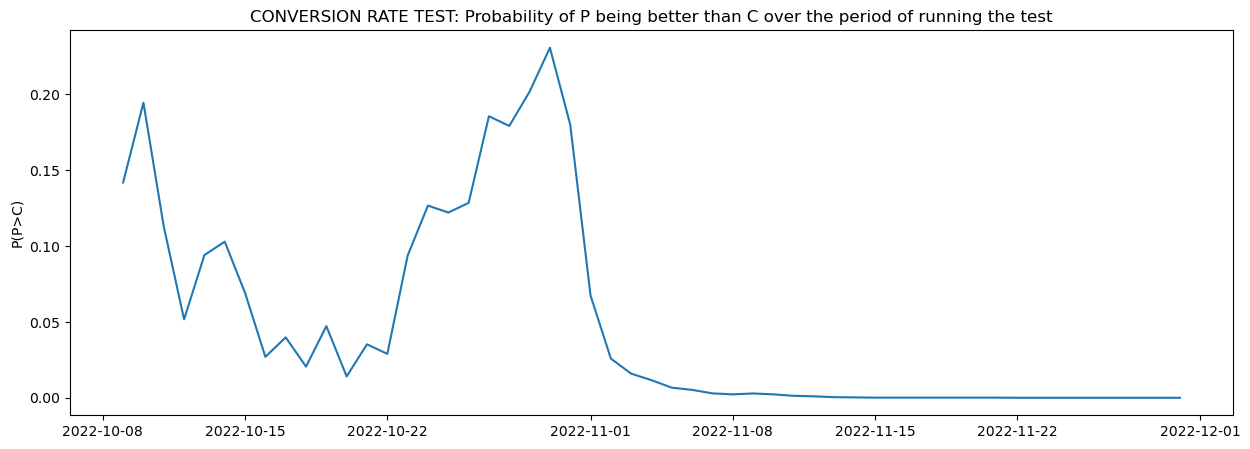

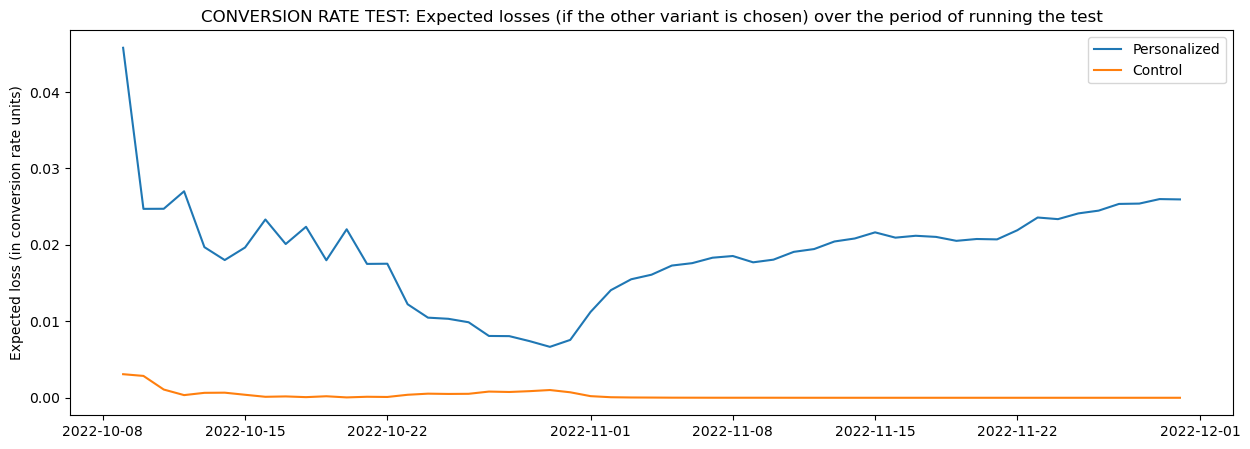

In [7]:
list_probabs_conv_test = []
list_losses_conv_test_P = []
list_losses_conv_test_C = []
list_conversion_rates_P = []
list_conversion_rates_C = []

num_datapoints_P = 0
num_datapoints_C = 0
num_conversions_P = 0
num_conversions_C = 0

a_prior_conv_test_C = 0.5
b_prior_conv_test_C = 0.5
a_prior_conv_test_P = 0.5
b_prior_conv_test_P = 0.5



list_probabs_revenue_test = []
list_losses_revenue_test_P = []
list_losses_revenue_test_C = []

a_prior_beta_revenue_test_P = 0.5
b_prior_beta_revenue_test_P = 0.5
m_prior_revenue_test_P = 1
a_prior_ig_revenue_test_P = 0
b_prior_ig_revenue_test_P = 0
w_prior_revenue_test_P = 0.01

a_prior_beta_revenue_test_C = 0.5
b_prior_beta_revenue_test_C = 0.5
m_prior_revenue_test_C = 1
a_prior_ig_revenue_test_C = 0
b_prior_ig_revenue_test_C = 0
w_prior_revenue_test_C = 0.01


for current_date in dates_list:
    print(current_date)
    daily_data = initial_data[initial_data.meta_date == current_date].copy()
    daily_data['conversions'] = daily_data['total_wins_spend'] > 0
    df_P = daily_data.loc[(daily_data["test_group"].str.lower() == "p")
            | (daily_data["test_group"].str.lower() == "assetario")]
    df_C = daily_data.loc[(daily_data["test_group"].str.lower() == "c")
            | (daily_data["test_group"].str.lower() == "control")]

    #################################################################
    # CONVERSION RATE TEST
    test_conversion = BinaryDataTest()

    test_conversion.add_variant_data(name = "P", data = df_P["conversions"].values, a_prior = a_prior_conv_test_P, b_prior = b_prior_conv_test_P)
    test_conversion.add_variant_data(name = "C", data = df_C["conversions"].values, a_prior = a_prior_conv_test_C, b_prior = b_prior_conv_test_C)

    a_prior_conv_test_P = test_conversion.data['P']['a_posterior']
    b_prior_conv_test_P = test_conversion.data['P']['b_posterior']
    a_prior_conv_test_C = test_conversion.data['C']['a_posterior']
    b_prior_conv_test_C = test_conversion.data['C']['b_posterior']

    res_conv_test = test_conversion.evaluate(seed=42)
    list_probabs_conv_test.append(res_conv_test[0]['prob_being_best'])
    list_losses_conv_test_P.append(res_conv_test[0]['expected_loss'])
    list_losses_conv_test_C.append(res_conv_test[1]['expected_loss'])

    num_datapoints_P += df_P.shape[0]
    num_conversions_P += df_P[df_P.total_wins_spend > 0].shape[0]
    num_datapoints_C += df_C.shape[0]
    num_conversions_C += df_C[df_C.total_wins_spend > 0].shape[0]

    list_conversion_rates_P.append(num_conversions_P/num_datapoints_P)
    list_conversion_rates_C.append(num_conversions_C/num_datapoints_C)
    #################################################################

    #################################################################
    # REVENUE TEST
    test_revenue = DeltaLognormalDataTest()
    test_revenue.add_variant_data(name = "P", data = df_P["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_P, b_prior_beta = b_prior_beta_revenue_test_P, 
                                        m_prior = m_prior_revenue_test_P, a_prior_ig = a_prior_ig_revenue_test_P, b_prior_ig = b_prior_ig_revenue_test_P, w_prior = w_prior_revenue_test_P)
    test_revenue.add_variant_data(name = "C", data = df_C["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_C, b_prior_beta = b_prior_beta_revenue_test_C, 
                                        m_prior = m_prior_revenue_test_C, a_prior_ig = a_prior_ig_revenue_test_C, b_prior_ig = b_prior_ig_revenue_test_C, w_prior = w_prior_revenue_test_C)

    a_prior_beta_revenue_test_P = test_revenue.data['P']['a_post_beta']
    b_prior_beta_revenue_test_P = test_revenue.data['P']['b_post_beta']
    m_prior_revenue_test_P = test_revenue.data['P']['m_post']
    a_prior_ig_revenue_test_P = test_revenue.data['P']['a_post_ig']
    b_prior_ig_revenue_test_P = test_revenue.data['P']['b_post_ig']
    w_prior_revenue_test_P = test_revenue.data['P']['w_post']

    a_prior_beta_revenue_test_C = test_revenue.data['C']['a_post_beta']
    b_prior_beta_revenue_test_C = test_revenue.data['C']['b_post_beta']
    m_prior_revenue_test_C = test_revenue.data['C']['m_post']
    a_prior_ig_revenue_test_C = test_revenue.data['C']['a_post_ig']
    b_prior_ig_revenue_test_C = test_revenue.data['C']['b_post_ig']
    w_prior_revenue_test_C = test_revenue.data['C']['w_post']

    res_revenue_test = test_revenue.evaluate(seed=42)
    list_probabs_revenue_test.append(res_revenue_test[0]['prob_being_best'])
    list_losses_revenue_test_P.append(res_revenue_test[0]['expected_loss'])
    list_losses_revenue_test_C.append(res_revenue_test[1]['expected_loss'])

#     print('a_posterior_beta_revenue_test_P:', test_revenue.data['P']['a_post_beta'])
#     print('b_posterior_beta_revenue_test_P:', test_revenue.data['P']['b_post_beta'])
#     print('m_posterior_revenue_test_P:', test_revenue.data['P']['m_post'])
#     print('a_posterior_ig_revenue_test_P:', test_revenue.data['P']['a_post_ig'])
#     print('b_posterior_ig_revenue_test_P:', test_revenue.data['P']['b_post_ig'])
#     print('w_posterior_revenue_test_P:', test_revenue.data['P']['w_post'])

#     print('a_posterior_beta_revenue_test_C:', test_revenue.data['C']['a_post_beta'])
#     print('b_posterior_beta_revenue_test_C:', test_revenue.data['C']['b_post_beta'])
#     print('m_posterior_revenue_test_C:', test_revenue.data['C']['m_post'])
#     print('a_posterior_ig_revenue_test_C:', test_revenue.data['C']['a_post_ig'])
#     print('b_posterior_ig_revenue_test_C:', test_revenue.data['C']['b_post_ig'])
#     print('w_posterior_revenue_test_C:', test_revenue.data['C']['w_post'])


    #################################################################

# fig, ax = plt.subplots(figsize = (15,5))
# ax.set_title('CONVERSION RATE TEST: Probability of P being better than C over the period of running the test')
# ax.set_ylabel('P(P>C)')
# sns.lineplot(x = dates_list, y = list_probabs_conv_test)


# fig, ax = plt.subplots(figsize = (15,5))
# ax.set_title('CONVERSION RATE TEST: Expected losses (if the other variant is chosen) over the period of running the test')
# ax.set_ylabel('Expected loss (in conversion rate units)')
# sns.lineplot(x = dates_list, y = list_losses_conv_test_P, label = 'Personalized')
# sns.lineplot(x = dates_list, y = list_losses_conv_test_C, label = 'Control')


# fig, ax = plt.subplots(figsize = (15,5))
# ax.set_title('CONVERSION RATE TEST: Estimated conversion rates over the period of running the test')
# ax.set_ylabel('Conversion rate')
# sns.lineplot(x = dates_list, y = list_conversion_rates_P, label = 'Personalized')
# sns.lineplot(x = dates_list, y = list_conversion_rates_C, label = 'Control')

fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('CONVERSION RATE TEST: Probability of P being better than C over the period of running the test')
ax.set_ylabel('P(P>C)')
sns.lineplot(x = dates_list, y = list_probabs_revenue_test)


fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('CONVERSION RATE TEST: Expected losses (if the other variant is chosen) over the period of running the test')
ax.set_ylabel('Expected loss (in conversion rate units)')
sns.lineplot(x = dates_list, y = list_losses_revenue_test_P, label = 'Personalized')
sns.lineplot(x = dates_list, y = list_losses_revenue_test_C, label = 'Control')

In [8]:
list_probabs_revenue_test

[0.14195, 0.1946]

In [21]:
list_probabs_revenue_test

[0.14195,
 0.03215,
 0.09445,
 0.0035,
 0.00305,
 0.0054,
 0.0,
 0.0,
 0.35895,
 0.0,
 0.0006,
 0.0,
 0.28695,
 0.002,
 0.6446,
 0.60735,
 0.0008,
 0.61485,
 0.9688,
 0.55345,
 0.37945,
 0.03275,
 0.0,
 0.0,
 0.0,
 0.006,
 0.07415,
 0.0,
 0.00085,
 0.0,
 0.0,
 0.30755,
 0.00155,
 0.0,
 0.0,
 0.0,
 0.00035,
 0.0,
 0.008,
 0.0,
 0.0372,
 0.0016,
 5e-05,
 5e-05,
 0.0,
 0.0,
 0.00405,
 0.0,
 0.0,
 0.0,
 0.0017,
 0.0,
 0.44385]

In [7]:
rng = np.random.default_rng(42)

In [10]:
rng.gamma(5,6,10)

array([38.8967894 , 29.68990227, 27.78279618, 41.01494059, 28.86460538,
       34.50725488, 33.05666873, 40.99909967, 25.67160823, 47.0231255 ])

In [123]:
res

[{'variant': 'P',
  'totals': 61347,
  'positives': 3343,
  'positive_rate': 0.05449,
  'prob_being_best': 0.6321,
  'expected_loss': 5.07e-05},
 {'variant': 'C',
  'totals': 25959,
  'positives': 1384,
  'positive_rate': 0.05331,
  'prob_being_best': 0.3679,
  'expected_loss': 0.0001198}]

In [118]:
test.data

{'P': {'totals': 61347,
  'positives': 3343,
  'a_prior': 160139.5,
  'b_prior': 3387618.5,
  'a_posterior': 163482.5,
  'b_posterior': 3445622.5},
 'C': {'totals': 25959,
  'positives': 1384,
  'a_prior': 67714.5,
  'b_prior': 1434089.5,
  'a_posterior': 69098.5,
  'b_posterior': 1458664.5}}

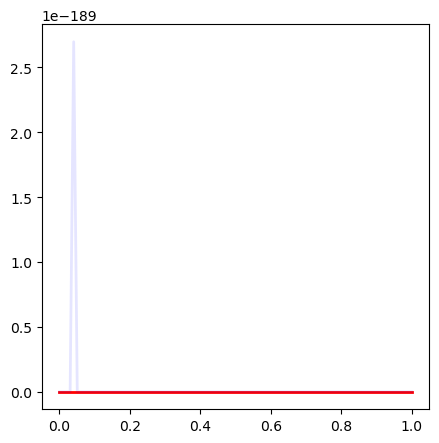

In [119]:
from scipy.stats import beta

x = np.linspace(0,
                1, 100)
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(x, beta.pdf(x, 163482.5, 3445622.5),
       'r-', lw=2, alpha=1, label='beta pdf')
ax.plot(x, beta.pdf(x, 69098.5, 1458664.5),
        'b-', lw=2, alpha=0.1, label='beta pdf')

In [144]:
x = np.linspace(0,1, 10000)

In [148]:
p_lambda_P = beta.pdf(x, 163482.5, 3445622.5)
p_lambda_C = beta.pdf(x, 69098.5, 1458664.5)

In [149]:
join_p_lambda_PC = np.zeros((1000,1000))

In [150]:
for i in range(1000):
    for j in range(1000):
        join_p_lambda_PC[i,j] = p_lambda_P[i]*p_lambda_C[j]

In [151]:
join_p_lambda_PC

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [152]:
error_A = 0
for i in range(1000):
    for j in range(1000):
        error_A += join_p_lambda_PC[i,j]

In [153]:
error_A

99980001.00810163

In [124]:
r = beta.rvs(163482.5, 3445622.5, size=10000)
r_2 = beta.rvs(69098.5, 1458664.5, size=10000)

In [135]:
count = 0
sum = 0

for i in range(10000):
    for j in range(10000):
        if r[i] < r_2[j]:
            sum += r_2[j] - r[i]
            count += 1

In [136]:
count

36139809

In [137]:
sum/10000/10000

4.927910349505899e-05

In [ ]:
list_conversion_rates_C

0.006715124785993921

<AxesSubplot:title={'center':'Probability of P being better than C'}, ylabel='P(P>C)'>

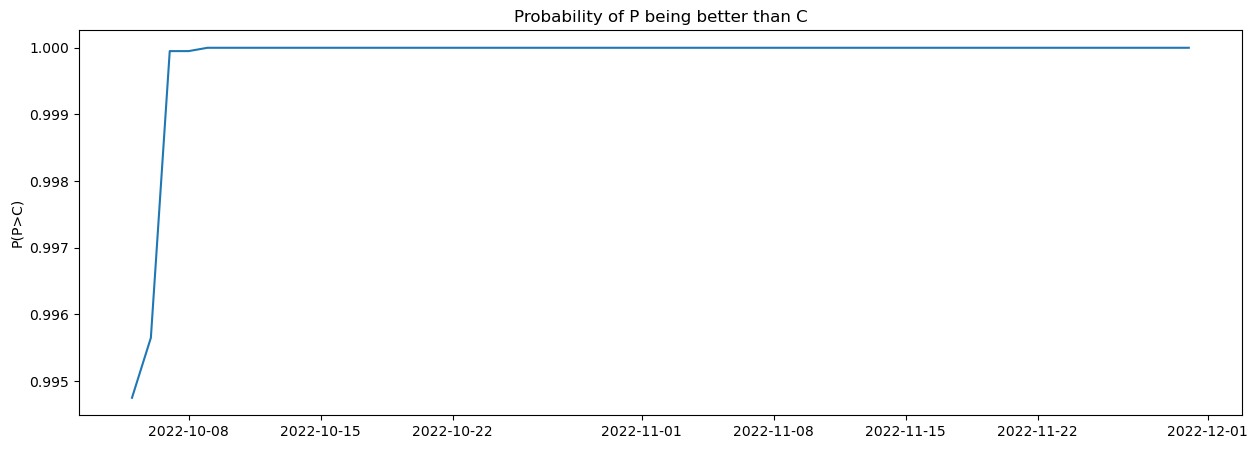

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('Probability of P being better than C')
ax.set_ylabel('P(P>C)')
sns.lineplot(x = dates_list, y = list_probabs)

<AxesSubplot:title={'center':'Expected losses (if the other variant is chosen) over the period of running the test'}, ylabel='Expected loss (in conversion rate units)'>

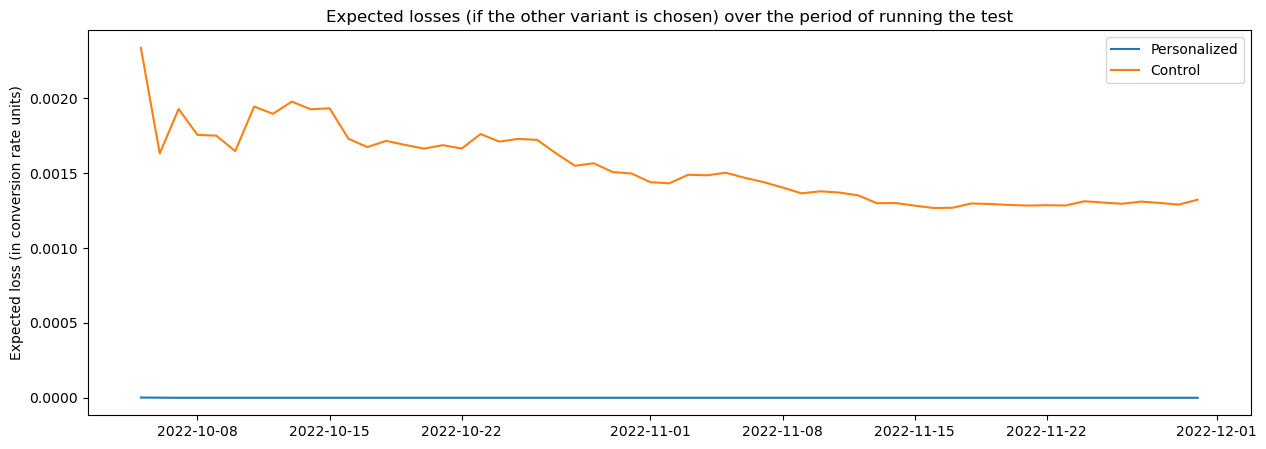

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('Expected losses (if the other variant is chosen) over the period of running the test')
ax.set_ylabel('Expected loss (in conversion rate units)')
sns.lineplot(x = dates_list, y = list_losses_P, label = 'Personalized')
sns.lineplot(x = dates_list, y = list_losses_C, label = 'Control')

In [12]:
list_probabs

[0.66375,
 0.67565,
 0.5962,
 0.73065,
 0.63945,
 0.65515,
 0.5962,
 0.6939,
 0.75805,
 0.79025,
 0.81645,
 0.7787,
 0.80775,
 0.70775,
 0.6458,
 0.6638,
 0.6721,
 0.65335,
 0.49415,
 0.525,
 0.6139,
 0.55725,
 0.5643,
 0.56015,
 0.51995,
 0.3774,
 0.31475,
 0.3371,
 0.3745,
 0.4257,
 0.53945,
 0.51275,
 0.544,
 0.5164,
 0.52175,
 0.47145,
 0.44965,
 0.4294,
 0.47225,
 0.4781,
 0.4651,
 0.48035,
 0.38935,
 0.4126,
 0.4213,
 0.42705,
 0.43905,
 0.46275,
 0.32975,
 0.3044,
 0.342,
 0.3681,
 0.40165,
 0.4867,
 0.5066,
 0.61595,
 0.65315]

In [ ]:
# Create test results:
result = ProducePredictions()
results_conversion = result.produce_results_conversion(initial_data)
results_revenue = result.produce_results_revenue(
    "lognorm", initial_data
    )
results_posterior_sample = result._produce_results_lognorm_dist_carry_value(
        initial_data
    )

In [ ]:
results_posterior_sample

[array([0.52245148, 0.53132972, 0.51742133, ..., 0.53349675, 0.53106417,
        0.52291713]),
 array([0.55426451, 0.55191728, 0.5508314 , ..., 0.55183089, 0.54911598,
        0.55112896])]

In [ ]:
results_revenue

[{'variant': 'P',
  'totals': 1682625,
  'positives': 63447,
  'sum_values': 900864.72404,
  'avg_values': 0.53539,
  'avg_positive_values': 14.1987,
  'prob_being_best': 0.0,
  'expected_loss': 0.024312},
 {'variant': 'C',
  'totals': 3912234,
  'positives': 154756,
  'sum_values': 2156304.22112,
  'avg_values': 0.55117,
  'avg_positive_values': 13.93357,
  'prob_being_best': 1.0,
  'expected_loss': 0.0}]

In [ ]:
        # Set up metrics:
        post_sample_A = results_posterior_sample[1]
        post_sample_B = results_posterior_sample[0]
        post_sample_uplift = (post_sample_B - post_sample_A) / post_sample_A
        post_sample_diff = post_sample_B - post_sample_A
        hdi_A = az.hdi(post_sample_A, hdi_prob=st.session_state.hdi)
        hdi_B = az.hdi(post_sample_B, hdi_prob=st.session_state.hdi)
        hdi_diff = az.hdi(post_sample_uplift, hdi_prob=st.session_state.hdi)
        hdi_diff_ab = az.hdi(post_sample_diff, hdi_prob=st.session_state.hdi)

In [34]:
spends = initial_data[initial_data.test_group == 'C'].total_wins_spend.values

In [30]:
initial_data[initial_data.test_group == 'C'].total_wins_spend.

0.1274643042973746

In [33]:
spends.shape

(1768382,)

In [61]:
list_means = []
for i in range(1000):
    print(i)
    list_means.append(np.mean(random.choices(list(spends), k = 100000)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<AxesSubplot:ylabel='Count'>

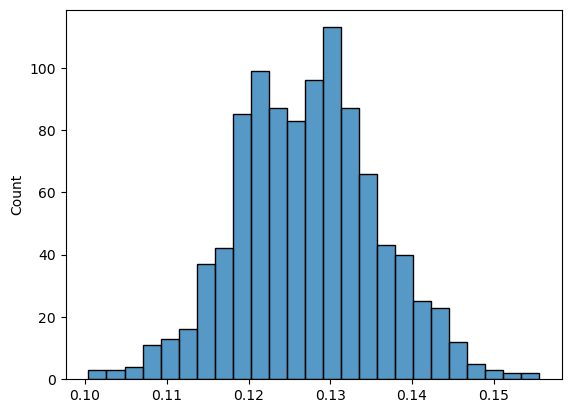

In [62]:
sns.histplot(list_means)

In [66]:
from scipy.stats import shapiro, kstest

In [65]:
shapiro(list_means)

ShapiroResult(statistic=0.9979486465454102, pvalue=0.26178932189941406)

In [67]:
kstest(list_means, 'norm')

KstestResult(statistic=0.5399937712898466, pvalue=1.873882896508576e-273)

In [7]:
query="""
        SELECT *
        FROM analytics__century_games_ncmgu__bingo_aloha_r3g9v.user_level_performance
        WHERE meta_date BETWEEN DATE '2022-11-01' AND DATE '2022-11-30';"""

In [8]:
initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
        query
    )

2023-01-02 14:53:48,510 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:573.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:6350.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:314153319|c


In [12]:
A = initial_data.groupby(['user_id', 'meta_date'])['first_login'].count().reset_index()

In [15]:
A[A.first_login > 1]

,user_id,meta_date,first_login
102,100100392,2022-11-22,2
104,100100392,2022-11-24,2
106,100100392,2022-11-29,2
228,100220854,2022-11-02,2
309,100270814,2022-11-13,2
...,...,...,...
2791773,99707523,2022-11-23,2
2791778,99707523,2022-11-28,2
2791779,99707523,2022-11-29,2
2791972,99791103,2022-11-22,2


In [17]:
initial_data[initial_data.user_id == '100100392'].sort_values('meta_date')

,user_id,meta_date,first_login,spend,wins_spend,os,group_tag,client_name,fl_personalized_offer_spend
898445,100100392,2022-11-04,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
656765,100100392,2022-11-08,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
1891791,100100392,2022-11-09,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
276438,100100392,2022-11-11,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
1613449,100100392,2022-11-12,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
99317,100100392,2022-11-13,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
1621301,100100392,2022-11-14,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
1687124,100100392,2022-11-21,2021-09-13,NaN,NaN,android,personalized,Bingo Aloha,<NA>
377305,100100392,2022-11-22,2021-09-13,1.99,1.99,android,personalized,Bingo Aloha,0
377306,100100392,2022-11-22,2021-09-13,2.99,2.99,android,personalized,Bingo Aloha,1


In [ ]:
5